# Binary logistic regression

In [2]:
pip install ucimlrepo

In [3]:
pip install optax

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import jax
from jax import numpy as jnp, grad
from scipy.optimize import minimize_scalar
import jax.numpy as jnp
from jax import grad, jit, hessian
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from ucimlrepo import fetch_ucirepo
from optax.losses import safe_softmax_cross_entropy as cros_entr
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize_scalar
import sklearn.datasets as skldata

# Set a random seed for reproducibility
np.random.seed(13)
jax.random.PRNGKey(13)

@jit
def logistic_loss(w, X, y, mu=1):
    m, n = X.shape
    return jnp.sum(jnp.logaddexp(0, -y * (X @ w))) / m + mu / 2 * jnp.sum(w**2)

def generate_problem(m=1000, n=300, mu=1):
    X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//2, random_state=0)
    X = jnp.array(X)
    y = jnp.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    return X_train, y_train, X_test, y_test

def compute_optimal(X, y, mu):
    w = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum(cp.logistic(cp.multiply(-y, X @ w))) / len(y) + mu / 2 * cp.norm(w, 2)**2)
    problem = cp.Problem(objective)
    problem.solve()
    return w.value, problem.value

@jit
def compute_accuracy(w, X, y):
    # Compute predicted probabilities using the logistic (sigmoid) function
    preds_probs = jax.nn.sigmoid(X @ w)
    # Convert probabilities to class predictions: -1 if p < 0.5, else 1
    preds = jnp.where(preds_probs < 0.5, 0, 1)
    # Calculate accuracy as the average of correct predictions
    accuracy = jnp.mean(preds == y)
    return accuracy



# @jit
def compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu):
    f = lambda w: logistic_loss(w, X_train, y_train, mu)
    metrics = {
        "f_gap": [jnp.abs(f(x) - f_star) for x in trajectory],
        "x_gap": [jnp.linalg.norm(x - x_star) for x in trajectory],
        "time": times,
        "train_acc": [compute_accuracy(x, X_train, y_train) for x in trajectory],
        "test_acc": [compute_accuracy(x, X_test, y_test) for x in trajectory],
    }
    return metrics

def gradient_descent(w_0, X, y, learning_rate=0.01, num_iters=100, mu=0):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: logistic_loss(w, X, y, mu)
    iter_start = time.time()
    for i in range(num_iters):
        grad_val = grad(f)(w)
        if learning_rate == "linesearch":
            # Simple line search implementation
            phi = lambda alpha: f(w - alpha*grad_val)
            result = minimize_scalar(fun=phi,
                                     bounds=(1e-3, 2e2)
                              )
            step_size = result.x
        else:
            step_size = learning_rate
        w -= step_size * grad_val
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)
    return trajectory, times

def newton_method(w_0, X, y, damping=2e-1, num_iters=100, mu=0):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: logistic_loss(w, X, y, mu)

    iter_start = time.time()
    for i in range(num_iters):
        gradient = grad(f)(w)
        hessian_matrix = hessian(f)(w)

        # Reshape the Hessian matrix
        hessian_reshaped = hessian_matrix.reshape(w.size, w.size)

        # Calculate the Newton step using the reshaped Hessian
        newton_step = jnp.linalg.solve(hessian_reshaped, gradient.ravel()).reshape(w.shape)

        # Update parameters using a damping factor
        w -= damping * newton_step

        # Store trajectory and time
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)

    return trajectory, times

def newton_method_cg(w_0, X, y, damping=2e-1, num_iters=100, mu=0):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: logistic_loss(w, X, y, mu)

    iter_start = time.time()
    for i in range(num_iters):
        gradient = grad(f)(w)
        hessian_matrix = hessian(f)(w)

        # Reshape the Hessian matrix
        hessian_reshaped = hessian_matrix.reshape(w.size, w.size)

        # Calculate the Newton step using the reshaped Hessian
        ### YOUR CODE HERE
        # newton_step =

        # Update parameters using a damping factor
        w -= damping * newton_step

        # Store trajectory and time
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)

    return trajectory, times

def newton_method_hfn(w_0, X, y, damping=2e-1, num_iters=100, mu=0):
    trajectory = [w_0]
    times = [0]
    w = w_0
    f = lambda w: logistic_loss(w, X, y, mu)

    iter_start = time.time()
    for i in range(num_iters):
        gradient = grad(f)(w)
        hessian_matrix = hessian(f)(w)

        # Reshape the Hessian matrix
        hessian_reshaped = hessian_matrix.reshape(w.size, w.size)

        # Calculate the Newton step using the reshaped Hessian
        ### YOUR CODE HERE
        # newton_step =

        # Update parameters using a damping factor
        w -= damping * newton_step

        # Store trajectory and time
        iter_time = time.time()
        trajectory.append(w)
        times.append(iter_time - iter_start)

    return trajectory, times

def run_experiments(params):
    mu = params["mu"]
    m, n = params["m"], params["n"]
    methods = params["methods"]
    results = {}

    X_train, y_train, X_test, y_test = generate_problem(m, n, mu)
    n_features = X_train.shape[1]  # Number of features
    params["n_features"] = n_features

    x_0 = jax.random.normal(jax.random.PRNGKey(0), (n_features, ))
    x_star, f_star = compute_optimal(X_train, y_train, mu)

    for method in methods:
        if method["method"] == "GD":
            learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = gradient_descent(x_0, X_train, y_train, learning_rate, iterations, mu)
            label = method["method"] + " " + str(learning_rate)
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu)
        elif method["method"] == "Newton":
            if "learning_rate" not in method.keys():
                learning_rate = 1
            else:
                learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            trajectory, times = newton_method(x_0, X_train, y_train, learning_rate, iterations, mu)
            label = method["method"] + " " + str(learning_rate)
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu)
        elif method["method"] == "Newton-CG":
            if "learning_rate" not in method.keys():
                learning_rate = 1
            else:
                learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            # trajectory, times = newton_method_cg(x_0, X_train, y_train, learning_rate, iterations, mu)
            label = method["method"] + " " + str(learning_rate)
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu)
        elif method["method"] == "Newton-HFN":
            if "learning_rate" not in method.keys():
                learning_rate = 1
            else:
                learning_rate = method["learning_rate"]
            iterations = method["iterations"]
            # trajectory, times = newton_method_hfn(x_0, X_train, y_train, learning_rate, iterations, mu)
            label = method["method"] + " " + str(learning_rate)
            results[label] = compute_metrics(trajectory, x_star, f_star, times, X_train, y_train, X_test, y_test, mu)

    return results, params

def plot_results(results, params):
    plt.figure(figsize=(11, 5))
    mu = params["mu"]

    if mu > 1e-2:
        plt.suptitle(f"Strongly convex binary logistic regression. mu={mu}.")
    else:
        plt.suptitle(f"Convex binary logistic regression. mu={mu}.")

    plt.subplot(2, 4, 1)
    for method, metrics in results.items():
        plt.plot(metrics['f_gap'])
    plt.xlabel('Iteration')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 2)
    for method, metrics in results.items():
        plt.plot(metrics['x_gap'], label=method)
    plt.xlabel('Iteration')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 3)
    for method, metrics in results.items():
        plt.plot(metrics["train_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 4)
    for method, metrics in results.items():
        plt.plot(metrics["test_acc"])
    plt.xlabel('Iteration')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 5)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['f_gap'])
    plt.xlabel('Time')
    plt.ylabel(r'$|f(x) -f^*|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 6)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics['x_gap'])
    plt.xlabel('Time')
    plt.ylabel('$\|x_k - x^*\|$')
    plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 7)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["train_acc"])
    plt.xlabel('Time')
    plt.ylabel('Train accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    plt.subplot(2, 4, 8)
    for method, metrics in results.items():
        plt.plot(metrics["time"], metrics["test_acc"])
    plt.xlabel('Time')
    plt.ylabel('Test accuracy')
    # plt.yscale('log')
    plt.grid(linestyle=":")

    # Place the legend below the plots
    plt.figlegend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.00))
    # Adjust layout to make space for the legend below
    filename = ""
    for method, metrics in results.items():
        filename += method
    filename += f"_{mu}.pdf"
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig(filename)
    plt.show()

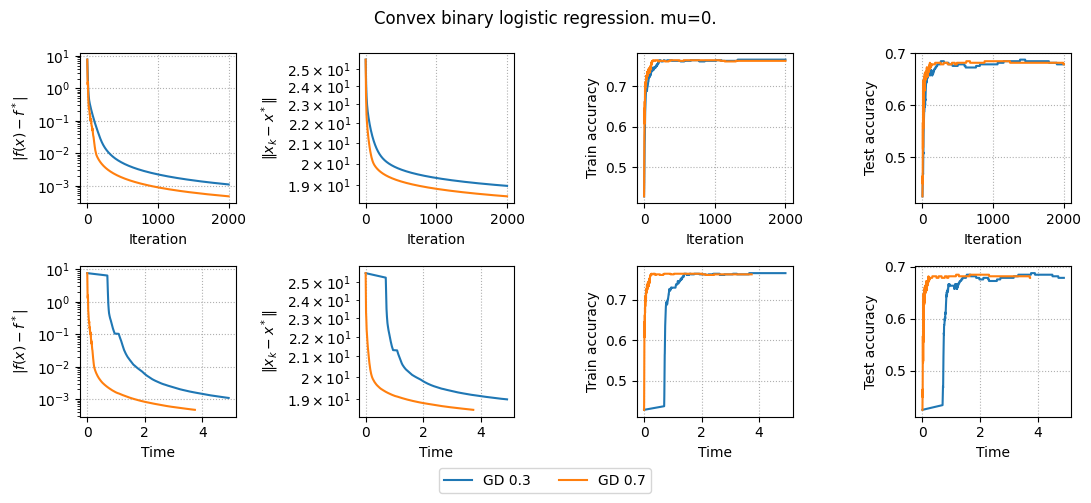

In [5]:
params = {
    "mu": 0,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 3e-1,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 7e-1,
            "iterations": 2000,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

### 1

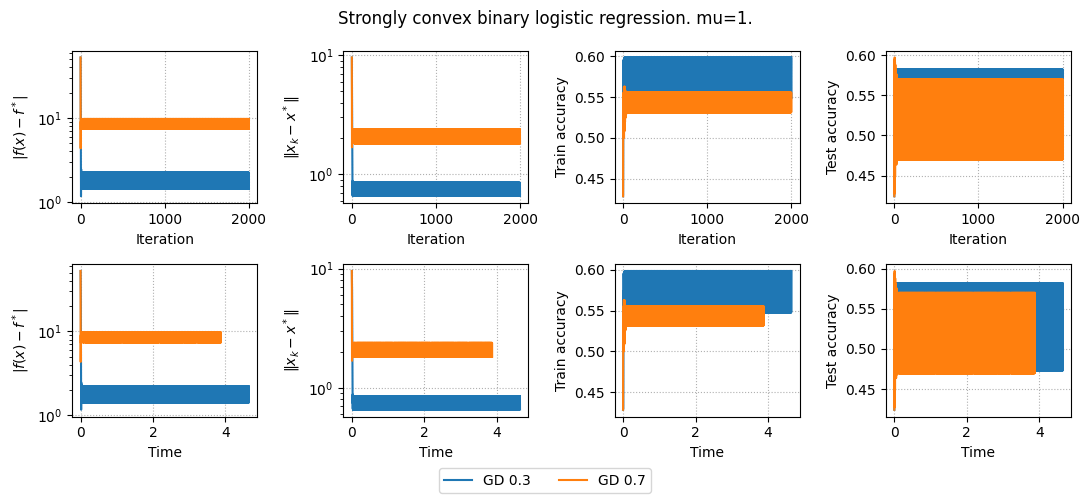

In [6]:
params = {
    "mu": 1,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 3e-1,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 7e-1,
            "iterations": 2000,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

Видим, что при learning rate=0.3, 0.7 сходимости нет

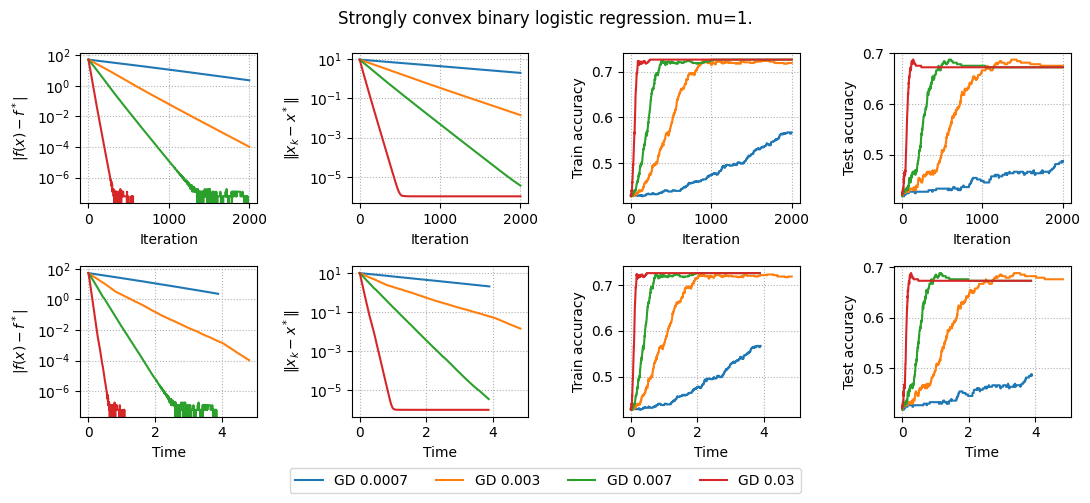

In [10]:
params = {
    "mu": 1,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 7e-4,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 3e-3,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 7e-3,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 3e-2,
            "iterations": 2000,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

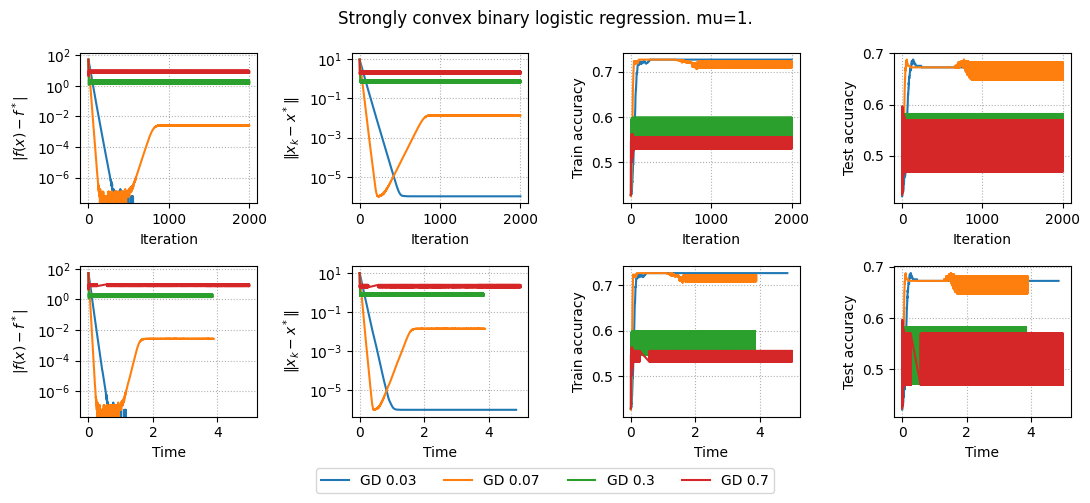

In [11]:
params = {
    "mu": 1,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 3e-2,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 7e-2,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 3e-1,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 7e-1,
            "iterations": 2000,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

тут видно, что сходится только при lr=3e-2, можно попробовать рассмотреть значения недалеко от этого

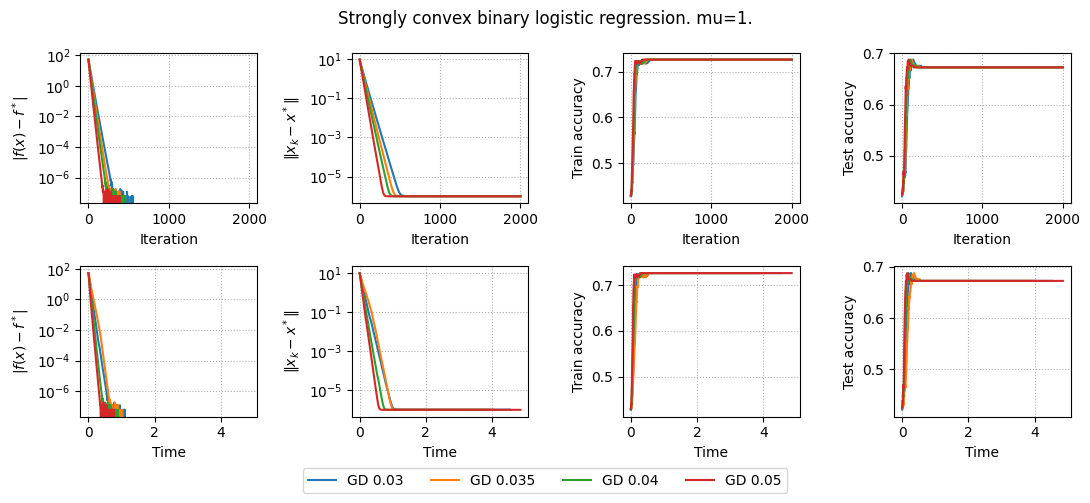

In [13]:
params = {
    "mu": 1,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 3e-2,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 0.035,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 4e-2,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 5e-2,
            "iterations": 2000,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

тут уже все сходятся, возьму ещё чуть больше

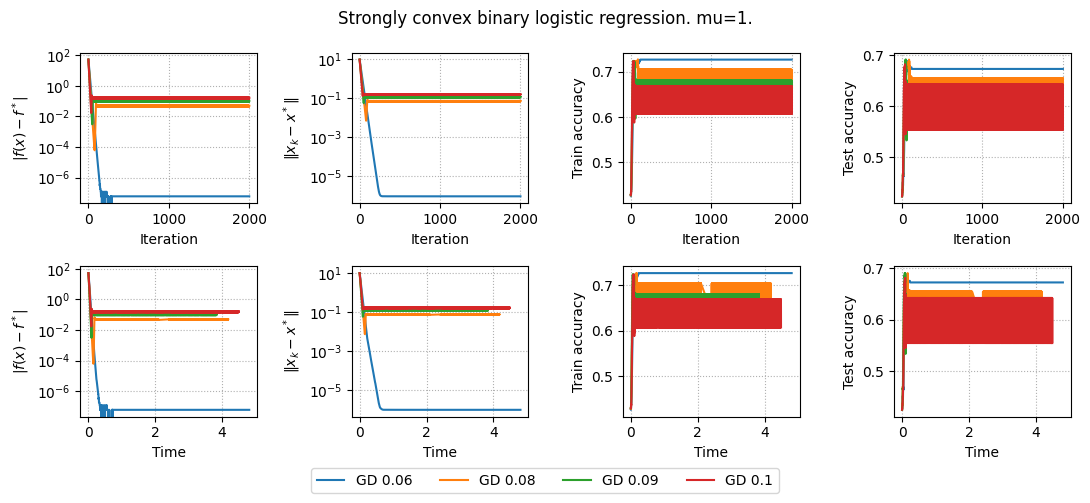

In [19]:
params = {
    "mu": 1,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 6e-2,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 8e-2,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 9e-2,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 1e-1,
            "iterations": 2000,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

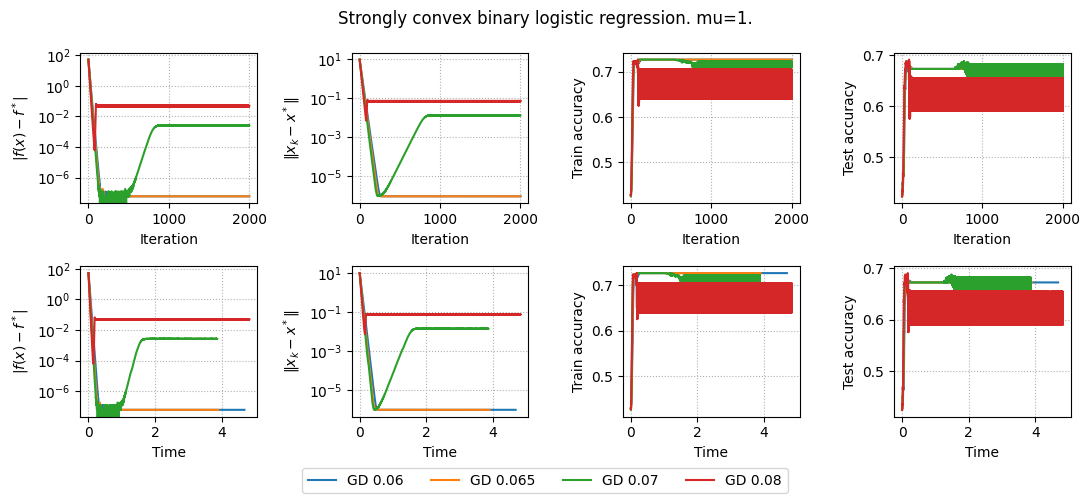

In [21]:
params = {
    "mu": 1,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 6e-2,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 0.065,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 7e-2,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 8e-2,
            "iterations": 2000,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

Так, ну максимальное число, при котором всё ещё есть сходимость - примерно 0.065, дальше уже расходится

### 2

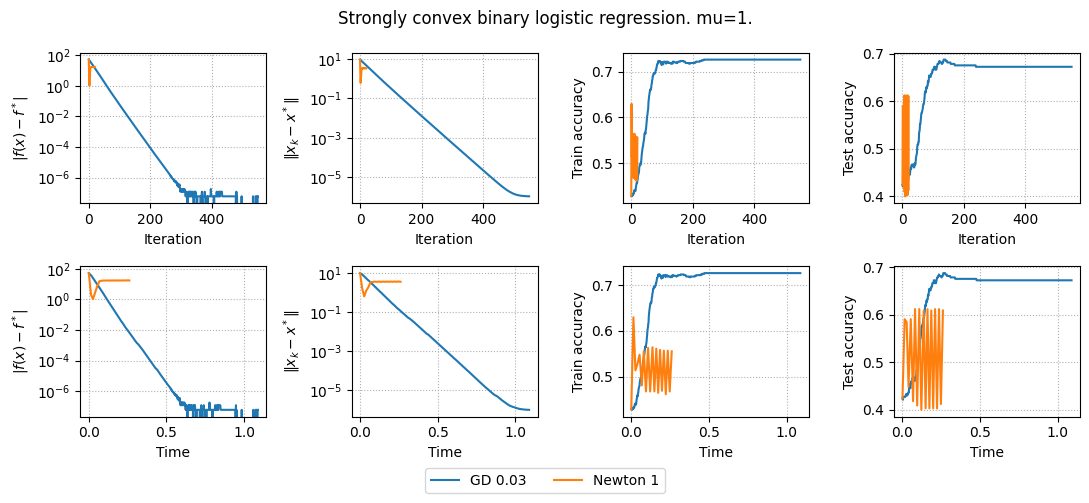

In [23]:
params = {
    "mu": 1,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 3e-2,
            "iterations": 550,
        },
        {
            "method": "Newton",
            "iterations": 20,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

### 3

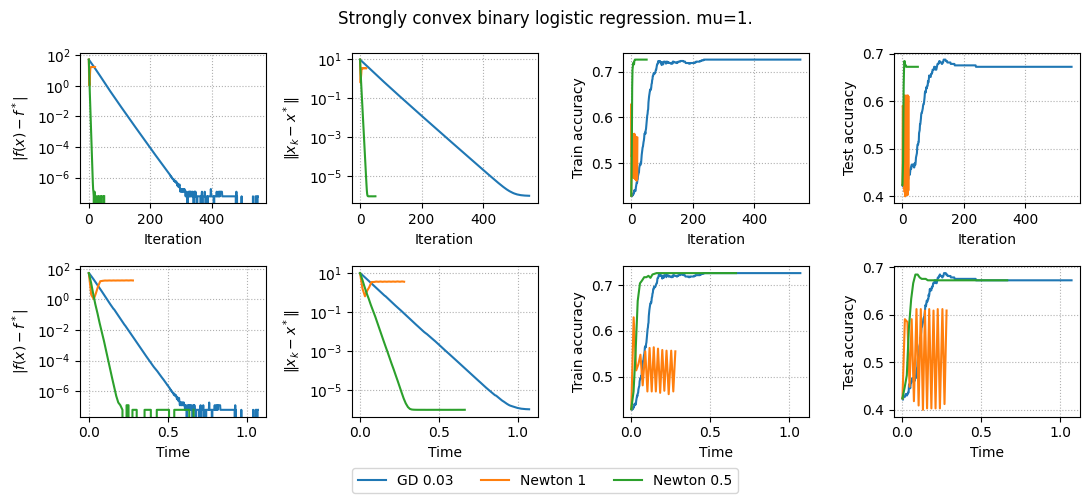

In [24]:
params = {
    "mu": 1,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 3e-2,
            "iterations": 550,
        },
        {
            "method": "Newton",
            "iterations": 20,
        },
        {
            "method": "Newton",
            "learning_rate": 5e-1,
            "iterations": 50,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

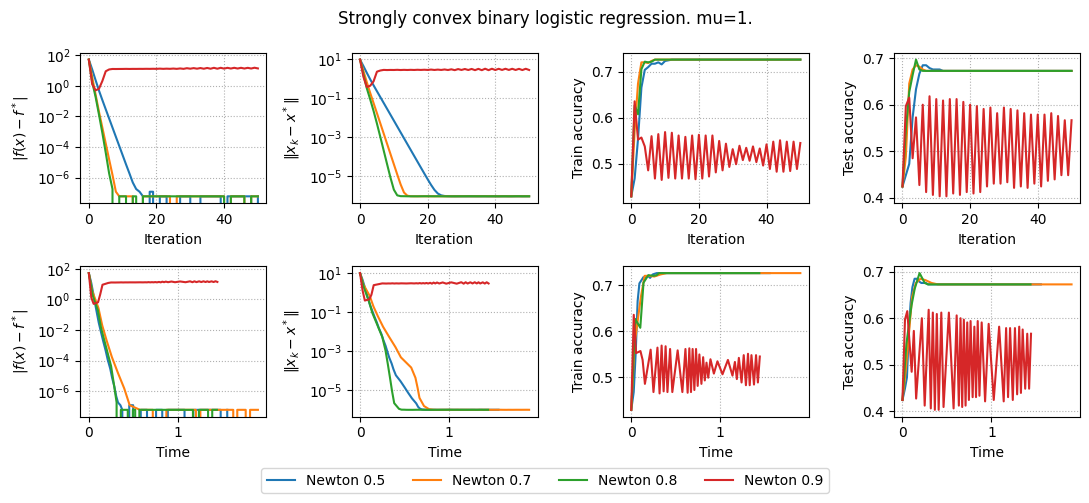

In [26]:
params = {
    "mu": 1,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "Newton",
            "learning_rate": 5e-1,
            "iterations": 50,
        },
        {
            "method": "Newton",
            "learning_rate": 7e-1,
            "iterations": 50,
        },
        {
            "method": "Newton",
            "learning_rate": 8e-1,
            "iterations": 50,
        },
        {
            "method": "Newton",
            "learning_rate": 9e-1,
            "iterations": 50,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

видимо, максимальный параметр -- это 0.8, потому уже не сходится

### 4

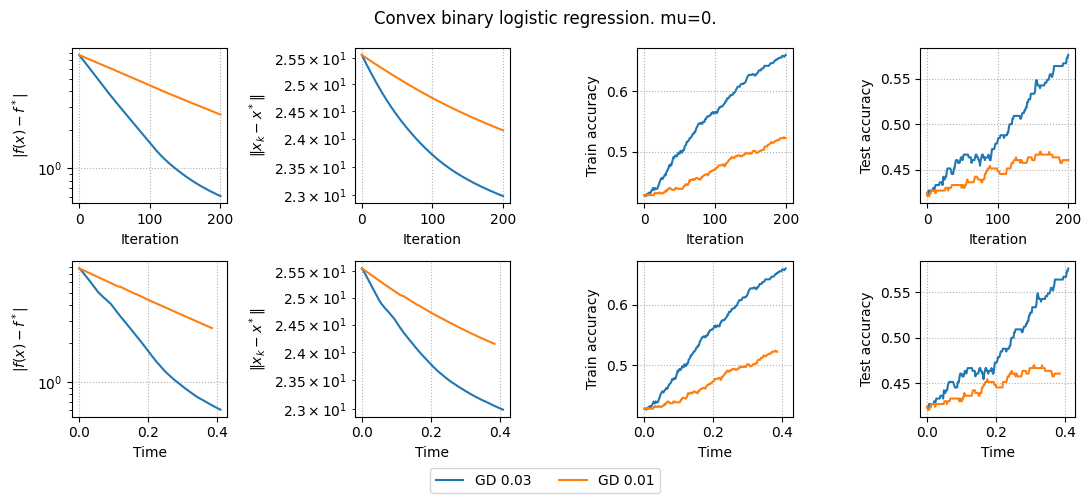

In [29]:
params = {
    "mu": 0,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 3e-2,
            "iterations": 200,
        },
        {
            "method": "GD",
            "learning_rate": 1e-2,
            "iterations": 200,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)

/Users/bratishka/.pyenv/versions/3.9.17/envs/benchmarx/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/Users/bratishka/.pyenv/versions/3.9.17/envs/benchmarx/lib/python3.9/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


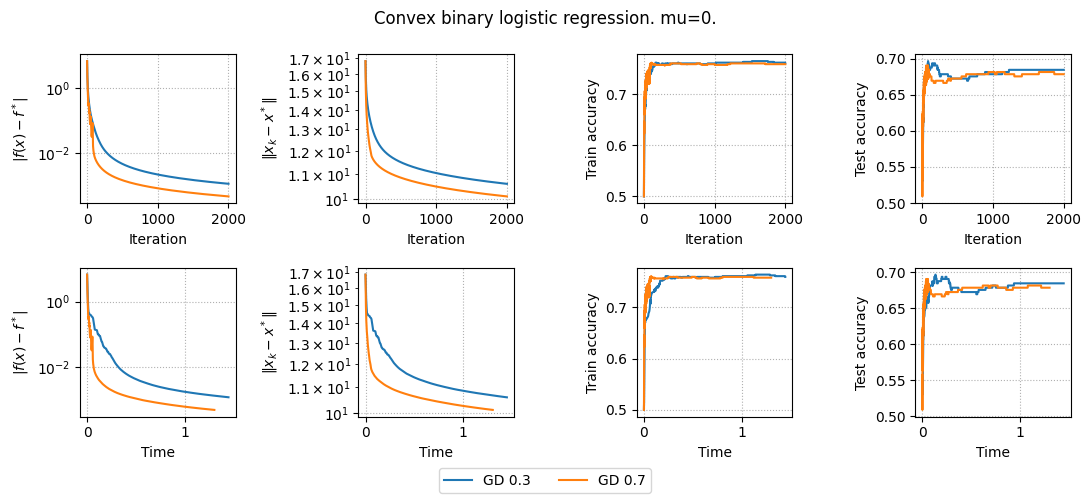

In [ ]:
params = {
    "mu": 0,
    "m": 1000,
    "n": 100,
    "methods": [
        {
            "method": "GD",
            "learning_rate": 3e-1,
            "iterations": 2000,
        },
        {
            "method": "GD",
            "learning_rate": 7e-1,
            "iterations": 2000,
        },
    ]
}

results, params = run_experiments(params)
plot_results(results, params)